In [1]:
from pathlib import Path
from typing import Any, Dict

import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, logging as hf_logging

# Quiet down noisy transformer warnings
hf_logging.set_verbosity_error()


/home/lateridiot/IT-371/Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-07 22:20:35.896744: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-07 22:20:36.102044: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-07 22:20:35.016649: I tensorflow/core/util/port.cc:153] oneDNN custom operations a

In [2]:
# Load and prepare input datasets
mails = pd.read_csv("input_data/enron_spam_data.csv")
mails.drop(labels=["Message ID", "Date", "Subject"], axis=1, inplace=True)
mails.dropna(subset=["Message"], inplace=True)
mails.rename(columns={"Message": "message", "Spam/Ham": "spam"}, inplace=True)
mails["spam"] = mails["spam"].map(lambda spam_ham: 1 if spam_ham == "spam" else 0)

train_data, test_data = train_test_split(mails, test_size=0.2, random_state=123, shuffle=True)
train_data.reset_index(inplace=True, drop=True)
test_data.reset_index(inplace=True, drop=True)


In [3]:
# Tokenizer and dataset setup
base_checkpoint = "distilbert-base-uncased"
checkpoint_dir = Path("spam-transformer-checkpoints/final")

# Prefer a previously fine-tuned checkpoint if it exists
if checkpoint_dir.exists():
    tokenizer = AutoTokenizer.from_pretrained(checkpoint_dir)
    print(f"Loaded tokenizer from {checkpoint_dir}")
else:
    tokenizer = AutoTokenizer.from_pretrained(base_checkpoint)
    print(f"Loaded tokenizer from base checkpoint: {base_checkpoint}")

class EmailDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer: AutoTokenizer, max_length: int = 256) -> None:
        self.texts = df["message"].tolist()
        self.labels = df["spam"].astype(int).tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        tokenized = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_length,
        )
        tokenized["labels"] = self.labels[idx]
        return tokenized

train_dataset = EmailDataset(train_data, tokenizer)
test_dataset = EmailDataset(test_data, tokenizer)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Loaded tokenizer from spam-transformer-checkpoints/final


In [4]:
# Train DistilBERT without the Trainer/accelerate dependency
id2label = {0: "Ham", 1: "Spam"}
label2id = {"Ham": 0, "Spam": 1}
needs_training = not checkpoint_dir.exists()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 8
num_epochs = 2
learning_rate = 2e-5
weight_decay = 0.01

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator)

if needs_training:
    model = AutoModelForSequenceClassification.from_pretrained(
        base_checkpoint,
        num_labels=2,
        id2label=id2label,
        label2id=label2id,
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs} - loss: {avg_loss:.4f}")

    # Save fine-tuned weights for inference
    checkpoint_dir.parent.mkdir(parents=True, exist_ok=True)
    model.save_pretrained(checkpoint_dir)
    tokenizer.save_pretrained(checkpoint_dir)
    print(f"Saved fine-tuned checkpoint to {checkpoint_dir}")
else:
    print(f"Checkpoint already exists at {checkpoint_dir}; skipping training.")


Checkpoint already exists at spam-transformer-checkpoints/final; skipping training.


In [5]:
# Evaluate on held-out test set using the fine-tuned checkpoint
if not checkpoint_dir.exists():
    raise RuntimeError("Checkpoint not found. Run the training cell first or ensure the checkpoint path exists.")

fine_tuned_model = AutoModelForSequenceClassification.from_pretrained(checkpoint_dir).to(device)
fine_tuned_model.eval()

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=data_collator)
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        labels = batch.pop("labels")
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = fine_tuned_model(**batch)
        preds = outputs.logits.argmax(dim=-1).cpu()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

y_pred = pd.Series(all_preds)
y_true = pd.Series(all_labels)

print(classification_report(y_true, y_pred, target_names=["Ham", "Spam"], digits=4))


              precision    recall  f1-score   support

         Ham     0.9928    0.9919    0.9923      3197
        Spam     0.9925    0.9934    0.9929      3472

    accuracy                         0.9927      6669
   macro avg     0.9927    0.9926    0.9926      6669
weighted avg     0.9927    0.9927    0.9927      6669



True Positive: 3449
False Negative: 23
True Negative: 3171
False Positive: 26


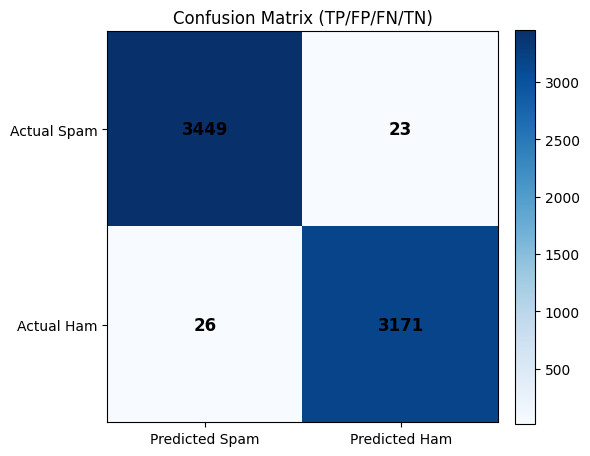

In [6]:
# Confusion matrix + TP/TN/FP/FN chart
tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

print(f"True Positive: {tp}")
print(f"False Negative: {fn}")
print(f"True Negative: {tn}")
print(f"False Positive: {fp}")

fig, ax = plt.subplots(figsize=(6, 6))
matrix = [[tp, fn], [fp, tn]]
im = ax.imshow(matrix, cmap="Blues")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Predicted Spam", "Predicted Ham"])
ax.set_yticks([0, 1])
ax.set_yticklabels(["Actual Spam", "Actual Ham"])

for (i, j), value in [((0, 0), tp), ((0, 1), fn), ((1, 0), fp), ((1, 1), tn)]:
    ax.text(j, i, f"{value}", ha="center", va="center", color="black", fontsize=12, fontweight="bold")

ax.set_title("Confusion Matrix (TP/FP/FN/TN)")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


In [9]:
# Reusable single-message inference helper
def predict_example(example_message: str) -> tuple[str, float]:
    """Return predicted label ('Ham'/'Spam') and spam probability for a message."""
    global fine_tuned_model
    if 'fine_tuned_model' not in globals():
        if not checkpoint_dir.exists():
            raise RuntimeError('Checkpoint not found. Run training first or point checkpoint_dir to a saved model.')
        fine_tuned_model = AutoModelForSequenceClassification.from_pretrained(checkpoint_dir).to(device)
    fine_tuned_model.eval()

    inputs = tokenizer(
        example_message,
        return_tensors='pt',
        truncation=True,
        max_length=256,
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = fine_tuned_model(**inputs).logits
        probs = logits.softmax(dim=-1).squeeze()
        spam_prob = float(probs[label2id['Spam']])
        pred_label = id2label[int(probs.argmax())]
    
    print(f"Message: {example_message}")
    print(f"Predicted class: {pred_label} (spam probability={spam_prob:.4f})")

In [10]:
predict_example("""
Dear Nayan,

Tomorrow is the last day to complete your student evaluations of teaching.

Enhancing the student experience requires your confidential feedback for the course(s) in which you are enrolled

Please complete your course evaluations today!

IT-371-001-Applied AI for IT (Sharmin Sultana) (Open)
Due Date: Monday, December 8, 2025 11:59 PM

You can also access your evaluation(s) via Canvas or via the Blue website using the following link:

https://my-gmu.bluera.com/

The information you provide is very important. The summary results from evaluations are used to assess both curricular and instructional quality and to identify opportunities for improvement.

Your participation is truly appreciated. If you require assistance or have any questions please contact the Office of Institutional Effectiveness and Planning at oiepset@gmu.edu.
""")

Message: 
Dear Nayan,

Tomorrow is the last day to complete your student evaluations of teaching.

Enhancing the student experience requires your confidential feedback for the course(s) in which you are enrolled

Please complete your course evaluations today!

IT-371-001-Applied AI for IT (Sharmin Sultana) (Open)
Due Date: Monday, December 8, 2025 11:59 PM

You can also access your evaluation(s) via Canvas or via the Blue website using the following link:

https://my-gmu.bluera.com/

The information you provide is very important. The summary results from evaluations are used to assess both curricular and instructional quality and to identify opportunities for improvement.

Your participation is truly appreciated. If you require assistance or have any questions please contact the Office of Institutional Effectiveness and Planning at oiepset@gmu.edu.

Predicted class: Ham (spam probability=0.1240)


In [11]:
predict_example("""
Dear user,

We attempted to renew your Cloud+ subscription, but your payment method has expired. As a result, your personal data is now at risk of being permanently removed from cloud.

What you could lose:

    Photos and videos stored in Cloud Photos
    Contacts, calendars, and reminders
    Notes, documents, and app data
    Device backups (iPhone, iPad, Mac)

ℹ️ Final Reminder:
Your data will be deleted if no action is taken by Tuesday, Nov 18 2025.

To prevent data loss, please update your payment information immediately and continue enjoying seamless access to your files across all Apple devices.
Update Payment & Secure My Data
Thank you for choosing Cloud.
— The Cloud Support Team
""")

Message: 
Dear user,

We attempted to renew your Cloud+ subscription, but your payment method has expired. As a result, your personal data is now at risk of being permanently removed from cloud.

What you could lose:

    Photos and videos stored in Cloud Photos
    Contacts, calendars, and reminders
    Notes, documents, and app data
    Device backups (iPhone, iPad, Mac)

ℹ️ Final Reminder:
Your data will be deleted if no action is taken by Tuesday, Nov 18 2025.

To prevent data loss, please update your payment information immediately and continue enjoying seamless access to your files across all Apple devices.
Update Payment & Secure My Data
Thank you for choosing Cloud.
— The Cloud Support Team

Predicted class: Spam (spam probability=0.9976)
